In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import Optional
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm.notebook import tqdm, trange

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from myutils.stats import corrcoef, acfunc
from myutils.matplotlib import matplotlib_seaborn_style

from src.missing_values import impute_average
from src.rzd import PlacePriceModel

matplotlib_seaborn_style()

In [3]:
results_dir = Path('../data/prediction')
results_dir.mkdir(exist_ok=True)

figures_dir = results_dir / 'figures'
figures_dir.mkdir(exist_ok=True)

In [4]:
data = pd.read_csv('../data/data.csv', parse_dates=['date'], encoding='utf-8')

data['weekday'] = data['date'].dt.weekday
data['day_name'] = data['date'].dt.day_name()

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

data.head(2)

,date,days,places,price,num,class,train,departure_hour,arrival_hour,places_frac,weekend,short_term,weekday,day_name
0,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000,0,1,0,Monday
1,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429,0,1,1,Tuesday


In [5]:
trains = sorted(data['train'].unique().tolist())
len(trains)

94

In [6]:
maxdays = 45

In [7]:
models = {}
metrics = []

all_places = []
all_places_filled = []
all_pcs = []
all_means = []
all_eigs = []

for train in tqdm(trains):
    train_data = data[data['train'] == train]

    places = train_data.pivot(index='date', columns='days', values='places_frac')
    prices = train_data.pivot(index='date', columns='days', values='price')
    
    places_filled = impute_average(places.values, low=places.min().min(), high=places.max().max())
    places_filled = pd.DataFrame(places_filled, index=places.index, columns=places.columns)
    
    for df in [places, prices, places_filled]:
        df.drop(columns=df.columns[df.columns > maxdays], inplace=True)
    
    model = PlacePriceModel(n_components=1)
    
    try:
        model.fit(places, prices)
        models[train] = model
        
        train_num, train_class = train.split('-')
        metrics.append((train_num, train_class, model.explained_variance, model.r2))
        
        idx = sorted(set(places.index.tolist()).intersection(set(model.a.index.tolist())))

        all_places.append(places.loc[idx])
        all_places_filled.append(places_filled.loc[idx])
        all_pcs.append(model.a.loc[idx])
        all_means.extend([model.mean] * len(idx))
        all_eigs.extend([model.v] * len(idx))

    except Exception as e:
        print(train, e)
    
metrics = pd.DataFrame(metrics, columns=['num', 'class', 'explained', 'r2'])
metrics['train'] = metrics['num'] + '-' + metrics['class']

metrics.to_csv(results_dir / 'model_metrics.csv', index=False)

metrics.head()

  0%|          | 0/94 [00:00<?, ?it/s]

,num,class,explained,r2,train
0,001А,Купе,0.745888,0.061599,001А-Купе
1,002А,Купе,0.770053,0.114732,002А-Купе
2,005А,СВ,0.746409,0.151784,005А-СВ
3,006А,СВ,0.786928,0.176904,006А-СВ
4,701Н,СВ,0.670818,0.164214,701Н-СВ


<AxesSubplot:xlabel='explained', ylabel='r2'>

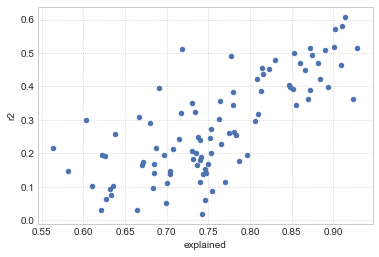

In [8]:
metrics.plot(kind='scatter', x='explained', y='r2')

In [9]:
all_places = pd.concat(all_places, axis=0, ignore_index=True)
all_places_filled = pd.concat(all_places_filled, axis=0, ignore_index=True)

all_pcs = pd.concat(all_pcs, ignore_index=True)
all_means = pd.DataFrame(all_means)
all_eigs = pd.DataFrame(all_eigs)

all_places_filled.shape, all_places.shape, all_pcs.shape, all_means.shape, all_eigs.shape

((7196, 45), (7196, 45), (7196,), (7196, 45), (7196, 45))

In [10]:
res = all_places - all_means - all_eigs.multiply(all_pcs, axis=0)

np.nanstd(res.values, ddof=1)

0.06429799744657609

In [11]:
feature_columns = all_places.columns[(all_places.columns > 30) & (all_places.columns <= 45)].tolist()

all_places[feature_columns].notna().all(axis=1).sum(), all_places[feature_columns].notna().all(axis=1).mean()

(1429, 0.19858254585881044)

In [12]:
predictor = DecisionTreeRegressor

  0%|          | 0/30 [00:00<?, ?it/s]

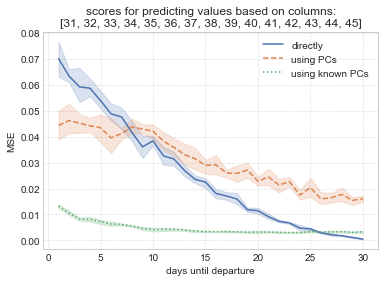

In [13]:
scores = []
pc_scores = []
known_pc_scores = []
pc_pred_scores = []

for target_column in trange(1, min(feature_columns)):
    mask = all_places[feature_columns + [target_column]].notna().all(axis=1) & all_pcs.notna()

    x = all_places.loc[mask, feature_columns].values
    
    y1 = all_places.loc[mask, target_column].values
    y2 = all_pcs[mask].values
    
    means = all_means.loc[mask, target_column].values
    eigs = all_eigs.loc[mask, target_column].values
    
    kfold = KFold(5, shuffle=True)
    
    for train_idx, test_idx in kfold.split(x):
        x_train = x[train_idx]
        y1_train = y1[train_idx]
        y2_train = y2[train_idx]
        
        model = predictor().fit(x_train, y1_train)
        model_pc = predictor().fit(x_train, y2_train)

        x_test = x[test_idx]
        y1_test = y1[test_idx]
        y2_test = y2[test_idx]
        
        score = mean_squared_error(model.predict(x_test), y1_test)
        scores.append((target_column, score))
        
        y2_pred = model_pc.predict(x_test)
        score = mean_squared_error(y2_pred, y2_test)
        pc_pred_scores.append((target_column, score))
        
        y1_pred = means[test_idx] + y2_pred * eigs[test_idx]
        score = mean_squared_error(y1_pred, y1_test)
        pc_scores.append((target_column, score))
        
        y2_pred = means[test_idx] + y2_test * eigs[test_idx]
        score = mean_squared_error(y2_pred, y1_test)
        known_pc_scores.append((target_column, score))
        
scores = pd.DataFrame(scores, columns=['target', 'mse'])
pc_scores = pd.DataFrame(pc_scores, columns=['target', 'mse'])
known_pc_scores = pd.DataFrame(known_pc_scores, columns=['target', 'mse'])
pc_pred_scores = pd.DataFrame(pc_pred_scores, columns=['target', 'mse'])

sns.lineplot(data=scores, x='target', y='mse', label='directly')
sns.lineplot(data=pc_scores, x='target', y='mse', label='using PCs', ls='dashed')
sns.lineplot(data=known_pc_scores, x='target', y='mse', label='using known PCs', ls='dotted')

plt.legend()
plt.title(f'scores for predicting values based on columns:\n{feature_columns}')
plt.xlabel('days until departure')
plt.ylabel('MSE')

plt.savefig(figures_dir / f'predicting_places_{predictor.__name__}.pdf',
            transparent=True, bbox_inches='tight')
plt.savefig(figures_dir / f'predicting_places_{predictor.__name__}.png',
            dpi=250, transparent=True, bbox_inches='tight')

  0%|          | 0/30 [00:00<?, ?it/s]

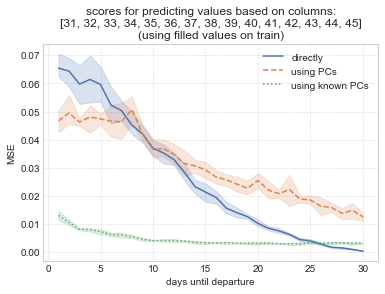

In [14]:
scores = []
pc_scores = []
known_pc_scores = []
pc_pred_scores = []

for target_column in trange(1, min(feature_columns)):
    mask = all_places[target_column].notna() & all_pcs.notna()

    x = all_places.loc[mask, feature_columns].values
    x_filled = all_places_filled.loc[mask, feature_columns].values
    
    y1 = all_places.loc[mask, target_column].values
    y2 = all_pcs[mask].values
    
    means = all_means.loc[mask, target_column].values
    eigs = all_eigs.loc[mask, target_column].values
    
    kfold = KFold(5, shuffle=True)
    
    for train_idx, test_idx in kfold.split(x):
        x_train = x_filled[train_idx]
        y1_train = y1[train_idx]
        y2_train = y2[train_idx]
        
        model = predictor().fit(x_train, y1_train)
        model_pc = predictor().fit(x_train, y2_train)

        x_test = x[test_idx]
        y1_test = y1[test_idx]
        y2_test = y2[test_idx]
        
        filled_mask = (~np.isnan(x_test)).all(axis=1)
        assert filled_mask.sum() >= 100
        
        x_test = x_test[filled_mask]
        y1_test = y1_test[filled_mask]
        y2_test = y2_test[filled_mask]
        
        score = mean_squared_error(model.predict(x_test), y1_test)
        scores.append((target_column, score))
        
        y2_pred = model_pc.predict(x_test)
        score = mean_squared_error(y2_pred, y2_test)
        pc_pred_scores.append((target_column, score))
        
        y1_pred = means[test_idx][filled_mask] + y2_pred * eigs[test_idx][filled_mask]
        score = mean_squared_error(y1_pred, y1_test)
        pc_scores.append((target_column, score))
        
        y2_pred = means[test_idx][filled_mask] + y2_test * eigs[test_idx][filled_mask]
        score = mean_squared_error(y2_pred, y1_test)
        known_pc_scores.append((target_column, score))
        
scores = pd.DataFrame(scores, columns=['target', 'mse'])
pc_scores = pd.DataFrame(pc_scores, columns=['target', 'mse'])
known_pc_scores = pd.DataFrame(known_pc_scores, columns=['target', 'mse'])
pc_pred_scores = pd.DataFrame(pc_pred_scores, columns=['target', 'mse'])

sns.lineplot(data=scores, x='target', y='mse', label='directly')
sns.lineplot(data=pc_scores, x='target', y='mse', label='using PCs', ls='dashed')
sns.lineplot(data=known_pc_scores, x='target', y='mse', label='using known PCs', ls='dotted')

plt.legend()
plt.title(f'scores for predicting values based on columns:\n{feature_columns}\n(using filled values on train)')
plt.xlabel('days until departure')
plt.ylabel('MSE')

plt.savefig(figures_dir / f'predicting_places_{predictor.__name__}_filled.pdf',
            transparent=True, bbox_inches='tight')
plt.savefig(figures_dir / f'predicting_places_{predictor.__name__}_filled.png',
            dpi=250, transparent=True, bbox_inches='tight')

In [15]:
!jupyter nbconvert --to html prediction.ipynb

[NbConvertApp] Converting notebook prediction.ipynb to html
[NbConvertApp] Writing 765051 bytes to prediction.html
